In [4]:

import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import math
import cv2
import os
#import PIL
from PIL import Image

C:\Users\Justin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
# dimensions of our images.
img_width, img_height = 224, 224

print (os.getcwd())
path = "C:/Users/Justin/Pictures/Lego"
os.chdir(path)
print (os.getcwd())

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

# number of epochs to train top model
epochs = 6
# batch size used by flow_from_directory and predict_generator
batch_size = 16

C:\Users\Justin\Documents\Python Scripts\JupyterNotebooks\Machine Learning pipeline
C:\Users\Justin\Pictures\Lego


In [3]:
def save_bottlebeck_features():
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    print(len(generator.filenames))
    print(generator.class_indices)
    print(len(generator.class_indices))

    nb_train_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    bottleneck_features_train = model.predict_generator(
        generator, predict_size_train)

    np.save('bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator.filenames)

    predict_size_validation = int(
        math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict_generator(
        generator, predict_size_validation)

    np.save('bottleneck_features_validation.npy',
            bottleneck_features_validation)

In [4]:
def train_top_model():
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    generator_top = datagen_top.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to use use later in predictions
    np.save('class_indices.npy', generator_top.class_indices)

    # load the bottleneck features saved earlier
    train_data = np.load('bottleneck_features_train.npy')

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes

    # https://github.com/fchollet/keras/issues/3467
    # convert the training labels to categorical vectors
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    generator_top = datagen_top.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_top.filenames)

    validation_data = np.load('bottleneck_features_validation.npy')

    validation_labels = generator_top.classes
    validation_labels = to_categorical(
        validation_labels, num_classes=num_classes)

    # add the top layers to the model 
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(
        validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("[INFO] Loss: {}".format(eval_loss))

    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

Found 3949 images belonging to 20 classes.
3949
{'Bionicle': 0, 'Castle': 1, 'City': 2, 'Creator': 3, 'DC': 4, 'Duplo': 5, 'Explore': 6, 'Fabuland': 7, 'HERO': 8, 'LEGOLAND': 9, 'Marvel': 10, 'Ninjago': 11, 'Racers': 12, 'Space': 13, 'Sports': 14, 'Star': 15, 'System': 16, 'Technic': 17, 'Town': 18, 'Trains': 19}
20
Found 494 images belonging to 20 classes.
Found 3949 images belonging to 20 classes.
Found 494 images belonging to 20 classes.
Train on 3949 samples, validate on 494 samples
Epoch 1/6
3949/3949 [==============================] - 16s 4ms/step - loss: 3.5029 - acc: 0.1367 - val_loss: 2.3566 - val_acc: 0.3138
Epoch 2/6
3949/3949 [==============================] - 16s 4ms/step - loss: 2.2638 - acc: 0.3013 - val_loss: 1.6715 - val_acc: 0.4636
Epoch 3/6
3949/3949 [==============================] - 16s 4ms/step - loss: 1.8310 - acc: 0.4490 - val_loss: 1.4720 - val_acc: 0.5729
Epoch 4/6
3949/3949 [==============================] - 16s 4ms/step - loss: 1.5073 - acc: 0.5558 - val_los

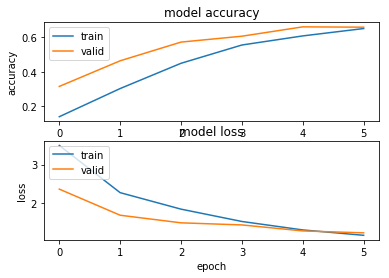

In [5]:
#train the model
save_bottlebeck_features()
train_top_model()
#predict()

#cv2.destroyAllWindows()

In [9]:
def build_model2(class_dictionary, num_classes):
    
    # build the VGG16 network
    model1 = applications.VGG16(include_top=False, weights='imagenet')
    #model2 = applications.VGG16(include_top=False, weights='imagenet')
    
    # build top model
    model2 = Sequential()
    model2.add(Flatten(input_shape=(7, 7, 512))) # (7, 7, 512) bottleneck_prediction.shape[1:]
    model2.add(Dense(256, activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(num_classes, activation='sigmoid'))

    model2.load_weights(top_model_weights_path)
    return model1, model2

In [10]:
def prediction2(image_name, class_dictionary, model_1, model_2):

    # add the path to your test image below
    image_path = image_name

    orig = cv2.imread(image_path)

    print("[INFO] loading and preprocessing image...")
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # important! otherwise the predictions will be '0'
    image = image / 255

    image = np.expand_dims(image, axis=0)

    # get the bottleneck prediction from the pre-trained VGG16 model
    bottleneck_prediction = model_1.predict(image)

    # use the bottleneck prediction on the top model to get the final
    # classification
    class_predicted = model_2.predict_classes(bottleneck_prediction)

    probabilities = model_2.predict_proba(bottleneck_prediction)

    inID = class_predicted[0]

    inv_map = {v: k for k, v in class_dictionary.items()}

    label = inv_map[inID]

    # get the prediction label
    #print("Image ID: {}, Label: {}".format(inID, label))
    return label

In [20]:
test_image_paths = []
test_image_directories = []

test_image_directories = os.listdir('data/test/')

for directory in test_image_directories:
    test_images = os.listdir('data/test/'+ directory)
    for timage in test_images:
        test_image_paths += [('data/test/'+ directory + '/' + timage, directory)]
    
print (len(test_image_paths))
print (test_image_paths[0:])

1
[('data/test/Technic/8260-1_Technic_2009.jpg', 'Technic')]


In [21]:
true = 0
total = 0

# load and calculate our constant variables
class_dictionary = np.load('class_indices.npy').item()
num_classes = len(class_dictionary)
model_1, model_2 = build_model2(class_dictionary, num_classes)

for candidate in test_image_paths[0:]:
    answer = prediction2(candidate[0], class_dictionary, model_1, model_2)
    print ("Actual: "+ candidate[1] + "        Predicted: " + answer)
    total += 1
    if candidate[1] == answer:
        print ("true")
        true +=1

print ('Percentage correct = ' + str(true/total*100))

[INFO] loading and preprocessing image...
Actual: Technic        Predicted: Technic
true
Percentage correct = 100.0
